In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import qiskit as qk

# The Superradiance Hamiltonian

First, let's write the Hamiltonian for superradiance.

$$ \text{H} = \text{H}_{at}+\text{H}_{rad} + \text{V} = \hbar\omega_0\sum_iD_i^3 + \sum_{k\epsilon}\hbar\omega_k(a_{k\epsilon}^\dagger a_{k\epsilon}+\frac{1}{2}) -\sum_i(\vec{E^+}(\vec{r}_i)+\vec{E^-}(\vec{r}_i))\cdot\vec{\mathscr{D}}_{ai}$$

Here, $ D_i^3$ in $\text{H}_{at}$ is the diagonal operator of the $\text{i}^{th}$ atom/two-level system. It takes an input in the excited (ground) state and produces an output in the excited (minus ground) state. Its appearance in the Hamiltonian accounts for the energy of the atoms themselves. It can be expanded in terms of the basis states $|g\rangle$ (ground) and $|e\rangle$ (excited) of the $\text{i}^{th}$ atom, $ D_i^3 = \frac{1}{2}\left(|e\rangle_i {}_i\langle e|-|g\rangle_i {}_i\langle g|\right)$. The sum over $i$ accounts for the energy contribution from all atoms in the system. 

The $\text{H}_{rad} $ term is the radiation/field part of the Hamiltonian and accounts for the creation ($a_{k\epsilon}^\dagger$) and annihilation ($a_{k\epsilon}$) of photons with wavevector $\vec{k}$ and polarization vector $\vec{\epsilon}$. The product ($a_{k\epsilon}^\dagger a_{k\epsilon}$) is the number operator for photons in mode $k\epsilon$ and counts the number of photons in that mode. The number of photons in that mode is multiplied by the energy of the mode ($\hbar\omega_k$) and the product is added to the vacuum (no photon) energy, $\frac{\hbar\omega_k}{2}$. To find the total energy of the field, we sum over all modes of the field.

The interaction part of the Hamiltonian, V, includes the sum of the positive and negative frequency components of the Electric Field operator, $\vec{E^+}$ + $\vec{E^-}$, dotted with the the electric dipole operator of the i$^{th}$ atom, $\vec{\mathscr{D}}_{ai}$.

$\vec{\mathscr{D}}_{ai}$ is defined by 

$$\vec{\mathscr{D}}_{ai} = (D_i^++D_i^-)d\vec{\epsilon}_a = (|e\rangle_i{}_i\langle g|+|g\rangle_i{}_i\langle e|)d\vec{\epsilon}_a$$,

where $D_i^{+(-)}$ is the raising (lowering) off-diagonal operators which raises (lowers) the energy of the i$^{th}$ atom from g (e) to e (g), d is the dipole matrix element of the transition, and $\epsilon_a$ is the normalized vector defining the polarization of the $|e\rangle \rightarrow |g\rangle$ transition.

The electric field operators are defined by

$$ \vec{E^+}(\vec{r}) = -i\sum_{k,\epsilon}\vec{\mathcal{E}}_{k\epsilon}a_{k\epsilon}e^{i\vec{k}\cdot\vec{r}}$$ 
and 
$$ \vec{E^-}(\vec{r}) = i\sum_{k,\epsilon}\vec{\mathcal{E}}_{k\epsilon}a_{k\epsilon}^\dagger e^{-i\vec{k}\cdot\vec{r}}$$
where 
$$\vec{\mathcal{E}}_{k\epsilon} = \sqrt{\frac{\hbar ck}{2\epsilon_0\mathscr{V}}}\vec{\epsilon}$$.

These are the positive and negative frequency parts of the overall electric field, $\vec{E}$. $\vec{\mathcal{E}}$ is referred to as the "electric field per photon" and $\bf{\text{I THINK}}$ has to do with the Rabi Freqiency. $\mathscr{V}$ is an arbitrary quantization volume much larger than the atomic sample.

In [2]:
#Define parameters
omega_0 = 1.0  #Angular frequency of photon emitted in |e> -> |g> transition
omega_k = 1.0 #Angular frequency of radiation field
hbar = 1.0
gamma = 0.1  #Decay rate for spontaneous emission

#Number of atoms in the superradiant system
N = 3

## Defining states and operators

In the next cell, we define the excited and ground states as well as the single atom off diagonal operators ($D_i^+$ and $D_i^-$) and the diagonal operator ($D_i^3$)

In [3]:
#States and operators
g_ket = qt.basis(2, 0)  #|g⟩ 
e_ket = qt.basis(2, 1)  #|e⟩ 
g_bra = g_ket.dag()      #⟨g|
e_bra = e_ket.dag()      #⟨e|

#Creation and Annihilation operators
a = qt.destroy(2) #Annihilation operator of radiation field mode
adag = a.dag() #Creation operator of radiation field mode


Dplus_i = e_ket * g_bra    #Raising operator
Dminus_i = g_ket * e_bra   #Lowering operator
D3_i = 0.5 * (e_ket * e_bra - g_ket * g_bra)  #Diagonal operator

We continue by defining the collective operators that act, as tensors, on all atoms in the system, $D^+$ and $D^-$ and ($D^3$).

Here we must create a matrix/tensor that operates on all atoms. In the analytical case we construct a tensor by doing tensor products between all of the operators of individual atoms. QuTiP is able to do this by using the **qt.tensor** function, which constructs a tensor product of the inputted quantum operators.

To best utilize this function, we must creat N tensors that act as the identity on all but one atom, then add those tensors together. Explicitly, we would create the first tensor by doing a tensor product between the individual operator on the first atom and the identity operator on all other atoms. We would add this to the the tensor product between the individual operator on the second atom and the identity operator on all other atoms, and so on until all the individual atoms have been accounted for. 

To do this, we utilize the QuTiP function **qt.qeye(n)**, which gives an identity operator of size/dimension n. Here we use n=2 since each atom is a 2-state atom. 

Using qt.tensor, we do a tensor product between a list of i identity operators, qt.eye(2) (accounting for all atoms UP TO the ith atom), the individual operator on the ith atom, and a list of of N-i-1 identity operators (accounting for all atoms AFTER the ith atom up to the final Nth atom).
 

In [4]:
#Define collective operators for N atoms
Dplus = sum([qt.tensor([qt.qeye(2)]*i + [Dplus_i] + [qt.qeye(2)]*(N-i-1)) for i in range(N)])
Dminus = Dplus.dag()

D3 = sum([qt.tensor([qt.qeye(2)]*i + [D3_i] + [qt.qeye(2)]*(N-i-1)) for i in range(N)])

## Defining the Hamiltonian

In [5]:
#Atomic Hamiltonian (summed for all atoms)
H_atom = hbar * omega_0 * D3


## Setting up the Dynamics

For superradiance, we are obviously interested in the photon emission rate over time. We solve for this by using the

In [6]:
#Time for simulation
t = np.linspace(0,50,500)

#Initial state (all excited)
psi_0 = qt.tensor([e_ket]*N)

### Solving the Master Equation

QuTiP has a built in function to solve for the time evolution of the systems density matrix, $\rho(t)$ by solving the system's master equation. This built in function is **qt.mesolve(H, psi0, tlist, c_ops, [operators])**. This function evolves an initial state, **psi_0**, using a given Hamiltonian, **H** and an optional set of collapse operators, **c_ops**. The output is state vector at arbitrary points in time, **tlist**, or the expectation values of the supplied **operators** which must be placed in a list.

The master equation of an open quantum system is given by

$$ \frac{d\rho}{dt} = -\frac{i}{\hbar}[\text{H},\rho]+\sum_i\mathcal{L}(c_i)\rho$$

Here, the first term is the unitary time evolution of the system coming from the Hamiltonian. The second term describes non-unitary time evolution processes like decoherence, emission, or absorption. $\mathcal{L}(c_i)$ is the Linblad superoperator of the i$^{th}$ collapse operator, $c_i$, which represents the dissipation in our present system. In our case, $\mathcal{L}(c_i)$ is the collapse operator which acts on all atoms in the ensemble and causes them each to collapse from the excited to the ground state. 

The output of qt.mesolve is generally stored in a variable. Here we store it in a variable simply calles **result**. There are multiple outputs that are stored in **result**, namely **result.states** which is gives the time evolved quantum states, $\psi(t)$, and **result.expect** which gives the expectation values of the input operators.

In [7]:
#Define observables that we want to measure

#Rate of photon emission for a single atom is the expectation value of 
W = gamma*Dplus*Dminus


# Collapse operators (decay channels)
c_ops = [np.sqrt(gamma) * Dminus]  # Collective decay operator

#Solve the master equation
result = qt.mesolve(H_atom, psi_0, t, c_ops, [W])

### A note on the Hamiltonian, collapse operators, and the dynamics

As the code stands, the Hamiltonian actually has no effect on the photon emission rate. The output is entirely dependent on the collaps operator, $\sqrt{\Gamma}D^-$. This will obviously change when we implement the field, interaction and driving parts of the Hamiltonian later.

In [8]:
#Extract photon emission rate (expectation value of Dplus_N*Dminus_N)
photon_emission_rate = result.expect[0]

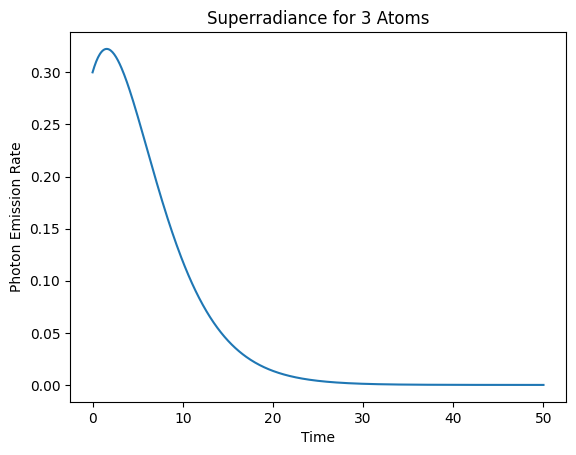

In [9]:
#Plot the photon emission rate
plt.plot(t, photon_emission_rate)
plt.xlabel('Time')
plt.ylabel('Photon Emission Rate')
plt.title(f'Superradiance for {N} Atoms')
plt.show()

We check that our solution makes sense by integrating the photon emission rate over all time and checking that the integral is equal to the number of atoms. This should be the case since each atom in the ensemble will release a single photon when it relaxes, and every atom should relax after a long time. 

In [10]:
from scipy.integrate import trapezoid

print(trapezoid(photon_emission_rate,t)/N) #Ratio of Integral of PER wrt t to N

0.9999856098055145


# Implementing a comparison to the non-coherent case 

Before we continue to implementing the field and interaction parts of the Hamiltonian, let's first make sure that we're _actually_ seeing superradiance. We'll do this by comparing the photon emission we found to the non-coherent spontaneous photon emission of a multi-atom system. 

# A New Old Observable

In the previous section, we needed only one observable to measure: the photon emission rate. Still we need only the photon emission rate, but the photon emission rate is defined differently for the superradiant and non-coherent cases. In the superradiant case, the emission rate is dependent on all atoms in the system, so we need to use the collective operators $D^+$ and $D^-$. In the non-coherent case, each atom emits independently, so we instead use the independent operators, $D_i^+$ and $D_i^-$.

In [11]:
#Rename observable (PER) emission rate for superradiant case
W_super = W

#For non-coherent case, the emission rate observable is the sum of individual emission rates
W_non_coherent = sum([gamma * qt.tensor([qt.qeye(2)] * i + [Dplus_i * Dminus_i] + [qt.qeye(2)] * (N-i-1)) for i in range(N)])

The collapse operators for the non coherent case must act on each two level system independently, not collectively. We define the collapse operators for this case in the following cell. It's very similar to the coherent case, but there is no interdependency between the atoms.

In [12]:
# Non-coherent Case: Independent collapse operators (one per atom)
c_ops_non_coherent = [qt.tensor([qt.qeye(2)] * i + [np.sqrt(gamma) * Dminus_i] + [qt.qeye(2)] * (N-i-1)) for i in range(N)]

In [13]:
#Rename the result of the resolved master equation
result_super = result

#Solve the master equation for non-coherent emission
result_non_coherent = qt.mesolve(H_atom, psi_0, t, c_ops_non_coherent, [W_non_coherent])

In [14]:
#Extract photon emission rates

#Rename the photon emission rate of the superradiant case
photon_emission_rate_super = photon_emission_rate

#Extract photon emission rate of non-coherent case
photon_emission_rate_non_coherent = result_non_coherent.expect[0]

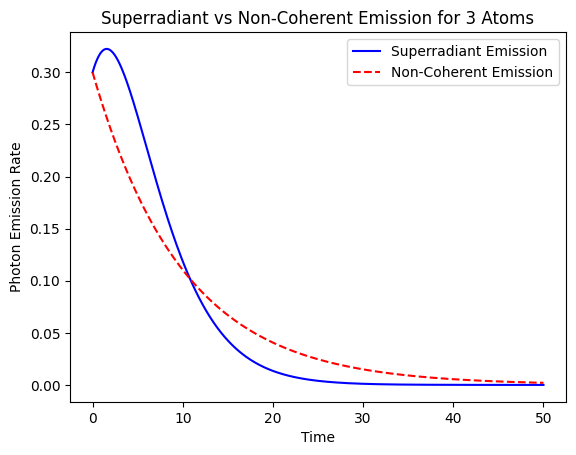

In [15]:
# Plot the results
plt.plot(t, photon_emission_rate_super, label='Superradiant Emission', color='blue')
plt.plot(t, photon_emission_rate_non_coherent, label='Non-Coherent Emission', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Photon Emission Rate')
plt.title(f'Superradiant vs Non-Coherent Emission for {N} Atoms')
plt.legend()
plt.show()

In [16]:
print('superradiance: ' + str(trapezoid(photon_emission_rate_super,t)/N)) #Ratio of Integral of PER wrt t to N
print('non coherent: ' + str(trapezoid(photon_emission_rate_non_coherent,t)/N)) #Ratio of Integral of PER wrt t to N

superradiance: 0.9999856098055145
non coherent: 0.9932704275276415


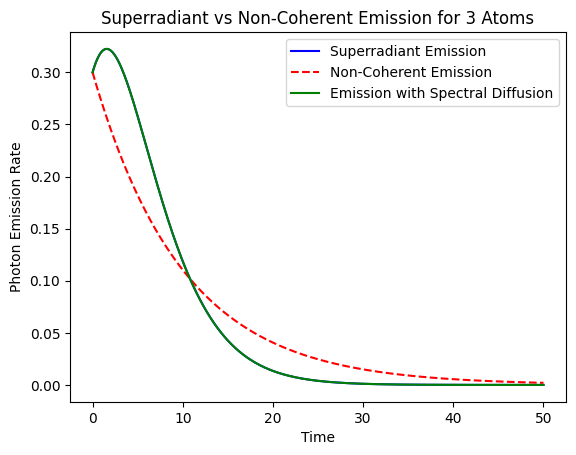

In [17]:
# Define the time-dependent detuning (slow variation over time)
def Delta_t(t):
    return np.random.normal(0, 10)  # Example: Gaussian noise

# Define time-dependent atomic Hamiltonian
def H_atom_t(t, args):
    return hbar * (omega_0 + Delta_t(t)) * D3

# Define time-dependent detuning for each atom
def Delta_i_t(i, t):
    # Gaussian noise as an example of time-dependent detuning
    return np.random.normal(0, 10)  # Detuning variance

# Define individual collapse operators for each atom with spectral diffusion
c_ops_spectral_diffusion = []
for i in range(N):
    # Create a phase factor based on the detuning and time
    phase_factor = np.exp(1j * Delta_i_t(i, t[-1]) * t[-1])  # Use last time point for phase factor
    # Create a collapse operator for each atom
    collapse_op = qt.tensor([qt.qeye(2)] * i + [np.sqrt(gamma) * Dminus_i * phase_factor] + [qt.qeye(2)] * (N - i - 1))
    c_ops_spectral_diffusion.append(collapse_op)

# Solve the master equation with time-dependent Hamiltonian
result_spectral_diffusion = qt.mesolve(H_atom_t, psi_0, t, c_ops, [W])

#Extract photon emission rate of non-coherent case
photon_emission_rate_spectral_diffusion = result_spectral_diffusion.expect[0]

# Plot the results
plt.plot(t, photon_emission_rate_super, label='Superradiant Emission', color='blue')
plt.plot(t, photon_emission_rate_non_coherent, label='Non-Coherent Emission', color='red', linestyle='--')
plt.plot(t, photon_emission_rate_spectral_diffusion, label='Emission with Spectral Diffusion', color='green', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Photon Emission Rate')
plt.title(f'Superradiant vs Non-Coherent Emission for {N} Atoms')
plt.legend()
plt.show()


# Rethinking the Collapse Operators

According to SUPERRADIANCE: AN ESSAY ON THE THEORY OF COLLECTIVE SPONTANEOUS EMISSION by M. Gross and S. Haroche, the master equation for superradiance is given by 

$$ \frac{d\rho}{dt} = \frac{1}{i\hbar}\left[ \sum_j H_j, \rho\right] - \frac{cd^2}{16\epsilon_0\pi^3\hbar}\int_0^{+\infty}d\tau\int_0^{+\infty}k^3dk\int d\Omega(\vec{\epsilon}\cdot\vec{\epsilon}_a)^2\sum_{ij}e^{i\vec{k}(\vec{r}_i-\vec{r}_j)-ick\tau}\left\{D_ie^{-iH_j\tau/\hbar}D_ie^{iH_j\tau/\hbar}\rho-e^{-iH_j\tau/\hbar}D_ie^{iH_j\tau/\hbar}\rho D_i\right\} + \text{Hermitian Conjugate of Integral}$$

Clearly, the collapse operators used above do not capture the complexity in the integral given by Gross and Haroche.

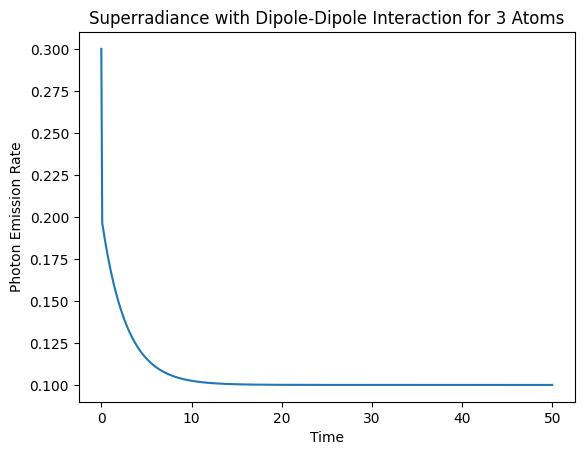

1.7584001735135584


In [18]:
#New Parameters
d = 1.0  # Dipole moment matrix element

#Define distances between atoms
positions = np.random.rand(N, 3) #Random positions in 3 dimensions. We might need to set these manually so that we can superradiance emerege when r = one wavelength.
r_ij = lambda i, j: np.linalg.norm(positions[i] - positions[j])  #Calculates the distance between atoms i and j 

#Define angular dependencies for dipole-dipole interaction
theta_ij = lambda i, j: np.arccos(np.dot(positions[i], positions[j]) / (np.linalg.norm(positions[i]) * np.linalg.norm(positions[j])))


#Construct dipole-dipole interaction collapse operators
collapse_operators = []
for i in range(N):
    for j in range(i+1, N): #Indices ensure that we don't double count r_ij and r_ji
        rij = r_ij(i, j)
        thetaij = theta_ij(i, j)
        gamma_ij = gamma * (1 + (3 * np.cos(thetaij)**2 - 1) / rij**3)
        
        #Real part: collective radiative decay
        c_ij = np.sqrt(gamma_ij) * qt.tensor([qt.qeye(2)]*i + [Dminus_i] + [qt.qeye(2)]*(N-i-1))
        collapse_operators.append(c_ij)
        
        # Imaginary part: dipole-dipole interaction
        V_ij = d**2 / (4 * np.pi * rij**3)
        collapse_operators.append(V_ij * qt.tensor([qt.qeye(2)]*i + [Dminus_i] + [qt.qeye(2)]*(N-i-1)))

# Solve the master equation with modified collapse operators
result = qt.mesolve(H_atom, psi_0, t, collapse_operators, [W_super])

# Extract and plot the photon emission rate
photon_emission_rate = result.expect[0]
plt.plot(t, photon_emission_rate)
plt.xlabel('Time')
plt.ylabel('Photon Emission Rate')
plt.title(f'Superradiance with Dipole-Dipole Interaction for {N} Atoms')
plt.show()

print(trapezoid(photon_emission_rate,t)/N) #Ratio of Integral of PER wrt t to N